# HoVer-Net Output Notebook

This repository enables the segmentation of nuclei in H&E whole-slide images (WSIs). For inference, we have incorporated two modes:

- Tile processing mode
- WSI processing mode

For tile processing, the input must be in a standard image format, such as `.jpg` or `.png`. <br />
For WSI processing, the input must be an [OpenSlide](https://openslide.org/) supported whole-slide image.

- Both tile and wsi processing modes output a `.json` file that contains:
        - bounding box coordinates for each nucleus
        - centroid coordinates for each nucleus
        - contour coordinates for each nucleus 
        - nucleus type predictions
        - per class probabilities for each nucleus (optional)
- tile mode also output a `.mat` and overlay file. The `.mat` file contains:
        - raw output of network (optional)
        - instance map containing values from 0 to N, where N is the number of nuclei
        - list of length N containing predictions for each nucleus
- wsi mode also produces a low resolution thumbnail and a tissue mask

In this notebook, we demonstrate how to utilise the output generated by these two different settings.

In [60]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json
import openslide

from misc.wsi_handler import get_file_handler
from misc.viz_utils import visualize_instances_dict

In [61]:
# first, we shall set the image tile, WSI and output paths.

wsi_path = r'\\10.162.80.12\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository'
wsi_output_path = r'\\10.162.80.12\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\cell_detection\notype\consep'

## WSI Processing Output

For WSI processing, our output is in json format and therefore we can apply a similar technique to what we saw above to extract the instance information. As well as the segmentation result, a low resolution thumbnail and mask is saved.

Below we will :
- Display the thumbnail and mask
- Show how to get a tile from a processed WSI and display the corresponding overlay.

In [62]:
# # get the list of all wsis
# wsi_list = glob.glob(wsi_path + '\*')
#
# # get a random wsi from the list
# rand_wsi = np.random.randint(0,len(wsi_list))
# wsi_file = wsi_list[rand_wsi]
# wsi_ext = '.svs'
#
# wsi_basename = os.path.basename(wsi_file)
# wsi_basename = wsi_basename[:-(len(wsi_ext))]

In [63]:
wsi_basename = '133'
wsi_ext = '.ndpi'
wsi_file = os.path.join(wsi_path,wsi_basename+wsi_ext);

In [64]:
()# read the thumbnail and mask from file

mask_path_wsi = os.path.join(*[wsi_output_path,'mask',wsi_basename+'.png'])
thumb_path_wsi = os.path.join(*[wsi_output_path, 'thumb',wsi_basename + '.png'])

In [65]:
thumb = cv2.cvtColor(cv2.imread(thumb_path_wsi), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(mask_path_wsi), cv2.COLOR_BGR2RGB)

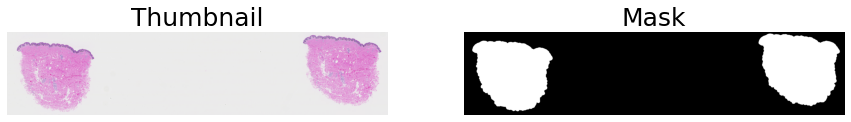

In [66]:
# plot the low resolution thumbnail along with the tissue mask

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(thumb)
plt.axis('off')
plt.title('Thumbnail', fontsize=25)

plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis('off')
plt.title('Mask', fontsize=25)

plt.show()

In [67]:
# load the json file (may take ~20 secs)

json_path_wsi = os.path.join(*[wsi_output_path,'json', wsi_basename + '.json'])

In [68]:
bbox_list_wsi = []
centroid_list_wsi = []
contour_list_wsi = [] 
type_list_wsi = []

# add results to individual lists
with open(json_path_wsi) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list_wsi.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list_wsi.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list_wsi.append(inst_bbox)
        inst_type = inst_info['type']
        type_list_wsi.append(inst_type)

In [69]:
# let's generate a tile from the WSI

# define the region to select
x_tile = 8676
y_tile = 4163
w_tile = 1000
h_tile = 1000

# load the wsi object and read region
wsi_obj = get_file_handler(wsi_file, wsi_ext)
wsi_obj.prepare_reading(read_mag=mag_info)
wsi_tile = wsi_obj.read_region((x_tile,y_tile), (w_tile,h_tile))

In [70]:
# only consider results that are within the tile

coords_xmin = x_tile
coords_xmax = x_tile + w_tile
coords_ymin = y_tile
coords_ymax = y_tile + h_tile

tile_info_dict = {}
count = 0
for idx, cnt in enumerate(contour_list_wsi):
    cnt_tmp = np.array(cnt)
    cnt_tmp = cnt_tmp[(cnt_tmp[:,0] >= coords_xmin) & (cnt_tmp[:,0] <= coords_xmax) & (cnt_tmp[:,1] >= coords_ymin) & (cnt_tmp[:,1] <= coords_ymax)] 
    label = str(type_list_wsi[idx])
    if cnt_tmp.shape[0] > 0:
        cnt_adj = np.round(cnt_tmp - np.array([x_tile,y_tile])).astype('int')
        tile_info_dict[idx] = {'contour': cnt_adj, 'type':label}
        count += 1

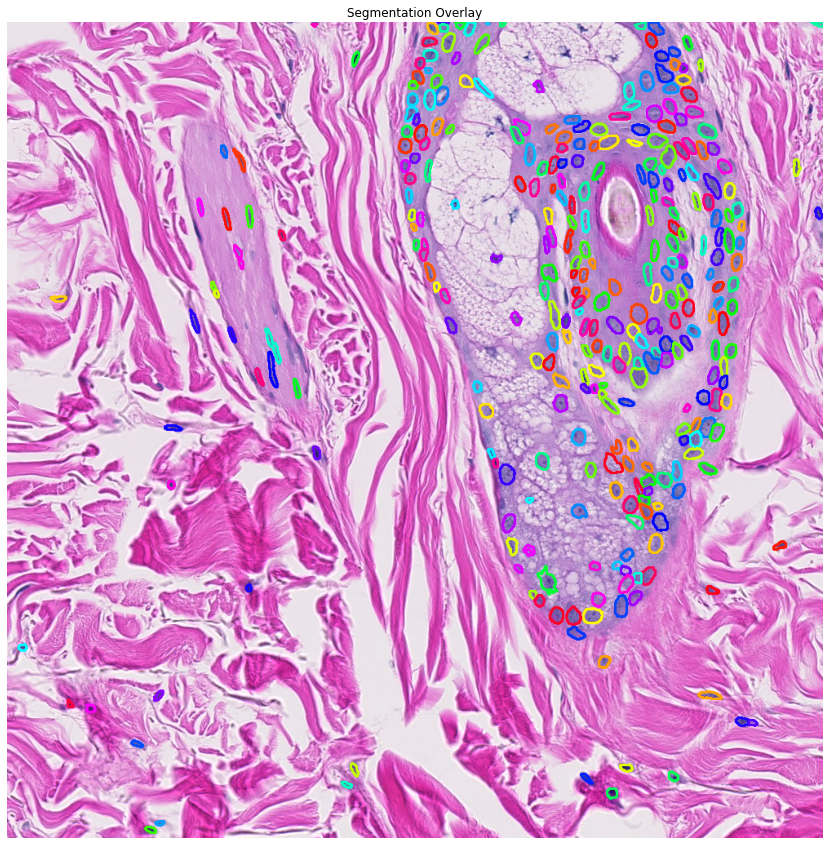

In [71]:
# plot the overlay

# the below dictionary is specific to PanNuke checkpoint - will need to modify depeending on categories used
type_info = {
    "0" : ["nolabe", [0  ,   0,   0]], 
    "1" : ["neopla", [255,   0,   0]], 
    "2" : ["inflam", [0  , 255,   0]], 
    "3" : ["connec", [0  ,   0, 255]], 
    "4" : ["necros", [255, 255,   0]], 
    "5" : ["no-neo", [255, 165,   0]] 
}

plt.figure(figsize=(18,15))
# overlaid_output = visualize_instances_dict(wsi_tile, tile_info_dict, type_colour=type_info)
overlaid_output = visualize_instances_dict(wsi_tile, tile_info_dict)

plt.imshow(overlaid_output)
plt.axis('off')
plt.title('Segmentation Overlay')
plt.show()

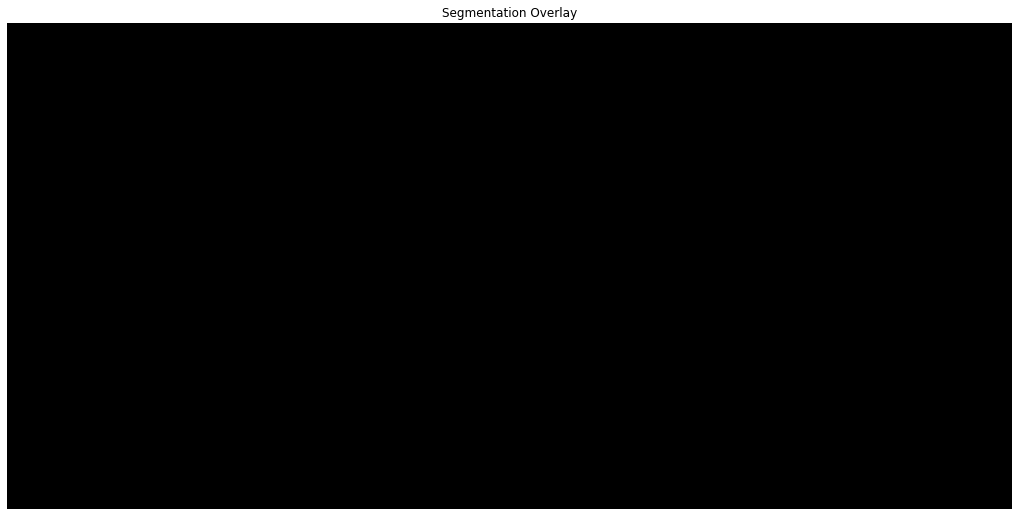

In [72]:
# define the region to select
x_tile = 67156
y_tile = 7000
lef = 68603
bot = 7700
w_tile = 1000
h_tile = 1000
w_tile = lef-x_tile
h_tile = bot-y_tile


# load the wsi object and read region
wsi_obj = get_file_handler(wsi_file, wsi_ext)
wsi_obj.prepare_reading(read_mag=mag_info)
wsi_tile = wsi_obj.read_region((x_tile,y_tile), (w_tile,h_tile))

# only consider results that are within the tile

coords_xmin = x_tile
coords_xmax = x_tile + w_tile
coords_ymin = y_tile
coords_ymax = y_tile + h_tile

tile_info_dict = {}
count = 0
for idx, cnt in enumerate(contour_list_wsi):
    cnt_tmp = np.array(cnt)
    cnt_tmp = cnt_tmp[(cnt_tmp[:,0] >= coords_xmin) & (cnt_tmp[:,0] <= coords_xmax) & (cnt_tmp[:,1] >= coords_ymin) & (cnt_tmp[:,1] <= coords_ymax)]
    label = str(type_list_wsi[idx])
    if cnt_tmp.shape[0] > 0:
        cnt_adj = np.round(cnt_tmp - np.array([x_tile,y_tile])).astype('int')
        tile_info_dict[idx] = {'contour': cnt_adj, 'type':label}
        count += 1

plt.figure(figsize=(18,15))
# overlaid_output = visualize_instances_dict(wsi_tile, tile_info_dict, type_colour=type_info)
overlaid_output = visualize_instances_dict(wsi_tile, tile_info_dict)

plt.imshow(overlaid_output)
plt.axis('off')
plt.title('Segmentation Overlay')
plt.show()